# 課題4: プロ野球選手の年俸データのクラスタリング

ここでは、k-means法を利用したクラスタリングの理解を深めて頂くための課題を用意しました。Lesson6で使用したプロ野球選手の推定年俸のデータを使い、クラスタリングを行ってください。なお、クラスタリングはデータを正規化したうえで行ないます。

わからない場合は、ここまでのレッスン内容や各種ライブラリの公式ドキュメントを参照しましょう。

## 1. ライブラリのimport

In [2]:
# （変更しないでください）

# 必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# データの正規化
from sklearn.preprocessing import MinMaxScaler

# k-means法
from sklearn.cluster import KMeans

# シルエットプロット
from sklearn.metrics import silhouette_score, silhouette_samples

# DataFrameですべての列を表示する設定
pd.options.display.max_columns = None

# seabornによる装飾を適用する
sns.set_theme()

In [3]:
# ===== 日本語フォント設定（Mac想定／文字化け対策）=====
# 優先的に使う日本語フォント候補（Mac標準 → 代替）
_jp_font_candidates = ["Hiragino Sans", "Hiragino Kaku Gothic ProN", "Hiragino Maru Gothic ProN", "IPAexGothic", "Noto Sans CJK JP"]
from matplotlib import font_manager, rcParams
_available = {f.name for f in font_manager.fontManager.ttflist}
for _f in _jp_font_candidates:
    if _f in _available:
        rcParams["font.family"] = _f
        break
# マイナス記号が豆腐になるのを防ぐ
rcParams["axes.unicode_minus"] = False

## 2. データの読み込み

CSVファイル *baseball_salary.csv* を読み込み、dataset_baseに格納します。

In [4]:
# CSVファイルを読み込んでdataset_baseに格納する
dataset_base = pd.read_csv("baseball_salary.csv")

In [5]:
# dataset_baseの最初の5行を表示
display(dataset_base.head())

,球団,推定年俸,守備,年数,年齢,身長,体重,血液型,投打,年,打率,試合,打席数,打数,安打,本塁打,打点,盗塁,四球,死球,三振,犠打,併殺打,出塁率,長打率,OPS,RC27,XR27,球団勝率,プレーオフ,球団平均得点,球団打率
0,c,21000,外野手,11,29,177,90,AB型,右左,2017,0.308,143,651,556,171,23,92,13,83,4,113,2,6,0.398,0.505,0.903,7.70,7.52,0.633,2,5.15,0.273
1,c,19000,内野手,7,28,171,72,A型,右右,2017,0.271,138,629,565,153,14,56,8,32,1,107,30,9,0.311,0.405,0.716,4.10,4.01,0.633,2,5.15,0.273
2,c,14000,内野手,5,29,171,85,A型,右左,2017,0.290,143,679,565,164,8,60,35,89,15,120,6,5,0.398,0.407,0.805,6.41,6.26,0.633,2,5.15,0.273
3,c,11500,内野手,7,38,196,126,不明,右右,2017,0.265,116,405,344,91,27,78,0,50,8,111,0,8,0.368,0.532,0.900,6.80,6.90,0.633,2,5.15,0.273
4,c,11000,内野手,20,41,189,102,B型,右右,2017,0.292,100,288,243,71,9,48,2,40,1,56,0,7,0.389,0.461,0.850,6.55,6.54,0.633,2,5.15,0.273


In [ ]:
# dataset_baseの中身の確認
# dataset_baseの情報（データ型・非欠損数）を表示
dataset_base.info()

# dataset_baseの数値・カテゴリの要約統計量を表示（カテゴリ列も含める）
dataset_base.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   球団      241 non-null    object 
 1   推定年俸    241 non-null    int64  
 2   守備      241 non-null    object 
 3   年数      241 non-null    int64  
 4   年齢      241 non-null    int64  
 5   身長      241 non-null    int64  
 6   体重      241 non-null    int64  
 7   血液型     241 non-null    object 
 8   投打      241 non-null    object 
 9   年       241 non-null    int64  
 10  打率      241 non-null    float64
 11  試合      241 non-null    int64  
 12  打席数     241 non-null    int64  
 13  打数      241 non-null    int64  
 14  安打      241 non-null    int64  
 15  本塁打     241 non-null    int64  
 16  打点      241 non-null    int64  
 17  盗塁      241 non-null    int64  
 18  四球      241 non-null    int64  
 19  死球      241 non-null    int64  
 20  三振      241 non-null    int64  
 21  犠打      241 non-null    int64  
 22  併殺

,球団,推定年俸,守備,年数,年齢,身長,体重,血液型,投打,年,打率,試合,打席数,打数,安打,本塁打,打点,盗塁,四球,死球,三振,犠打,併殺打,出塁率,長打率,OPS,RC27,XR27,球団勝率,プレーオフ,球団平均得点,球団打率
count,241,241.000000,241,241.000000,241.000000,241.000000,241.000000,241,241,241.0,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
unique,12,NaN,3,NaN,NaN,NaN,NaN,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,d,NaN,内野手,NaN,NaN,NaN,NaN,O型,右右,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,25,NaN,120,NaN,NaN,NaN,NaN,83,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6843.692946,NaN,8.248963,28.987552,179.141079,84.058091,NaN,NaN,2017.0,0.237324,73.605809,238.282158,210.207469,54.323651,5.651452,24.713693,3.398340,20.369295,2.078838,43.655602,4.336100,4.427386,0.301249,0.355797,0.657046,3.900996,3.897303,0.499577,1.074689,3.986639,0.250456
std,NaN,9613.580198,NaN,4.705964,4.736807,4.937612,9.940906,NaN,NaN,0.0,0.066306,45.171043,202.953533,178.444291,50.511334,8.150338,26.202357,6.255584,22.175825,2.716847,36.413849,7.123838,4.829156,0.075906,0.140497,0.199479,3.054494,2.873013,0.099943,1.327051,0.574845,0.011127
min,NaN,450.000000,NaN,2.000000,20.000000,163.000000,67.000000,NaN,NaN,2017.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.319000,0.000000,3.310000,0.233000
25%,NaN,1300.000000,NaN,4.000000,25.000000,176.000000,78.000000,NaN,NaN,2017.0,0.205000,34.000000,51.000000,46.000000,10.000000,0.000000,3.000000,0.000000,3.000000,0.000000,13.000000,0.000000,1.000000,0.263000,0.272000,0.542000,2.170000,2.270000,0.420000,0.000000,3.410000,0.242000
50%,NaN,2500.000000,NaN,7.000000,29.000000,179.000000,83.000000,NaN,NaN,2017.0,0.243000,74.000000,182.000000,162.000000,37.000000,2.000000,13.000000,1.000000,11.000000,1.000000,34.000000,1.000000,3.000000,0.304000,0.345000,0.639000,3.350000,3.400000,0.514000,0.000000,3.770000,0.249000
75%,NaN,7300.000000,NaN,12.000000,32.000000,182.000000,88.000000,NaN,NaN,2017.0,0.271000,112.000000,388.000000,344.000000,86.000000,6.000000,41.000000,4.000000,29.000000,3.000000,64.000000,6.000000,7.000000,0.339000,0.422000,0.755000,4.990000,4.860000,0.561000,2.000000,4.170000,0.254000


In [6]:
# dataset_baseから「打率、打点」列を抜き出してdatasetに格納する
dataset = dataset_base[['打率', '打点']].copy()

# 列名を、打率は「batting」、打点は「points」にリネームする
dataset.rename(columns={'打率': 'batting', '打点': 'points'}, inplace=True)

# datasetの先頭の5行を表示
dataset.head()

,batting,points
0,0.308,92
1,0.271,56
2,0.290,60
3,0.265,78
4,0.292,48


In [7]:
# 行数を表示
dataset.shape

(241, 2)

In [36]:
# datasetの中身の確認
## datasetの情報（データ型・非欠損数）を表示
dataset.info()

## datasetの数値・カテゴリの要約統計量を表示（カテゴリ列も含める）
dataset.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   batting         241 non-null    float64
 1   points          241 non-null    int64  
 2   batting_scaled  241 non-null    float64
 3   points_scaled   241 non-null    float64
 4   cluster         241 non-null    int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 8.6 KB


,batting,points,batting_scaled,points_scaled,cluster
count,241.000000,241.000000,241.000000,241.000000,241.000000
mean,0.237324,24.713693,0.474647,0.235369,2.580913
std,0.066306,26.202357,0.132612,0.249546,1.522980
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.205000,3.000000,0.410000,0.028571,2.000000
50%,0.243000,13.000000,0.486000,0.123810,3.000000
75%,0.271000,41.000000,0.542000,0.390476,4.000000
max,0.500000,105.000000,1.000000,1.000000,5.000000


## 3. データの正規化

クラスタリングは類似度（距離）に基づいて行なわれるため、データの範囲に差がある場合は正規化を行ないます。

ここでは、Lesson5のデータの前処理で紹介した *Min-max normalization* を使ってみましょう。 `sklearn.preprocessing.MinMaxScaler()` を利用します。

参考：https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [8]:
# MinMaxScalerで正規化を実施し、その結果を変数tempに格納する
scaler = MinMaxScaler()
temp = scaler.fit_transform(dataset[["batting", "points"]])
temp

array([[0.616     , 0.87619048],
       [0.542     , 0.53333333],
       [0.58      , 0.57142857],
       [0.53      , 0.74285714],
       [0.584     , 0.45714286],
       [0.6       , 0.85714286],
       [0.408     , 0.11428571],
       [0.652     , 0.73333333],
       [0.55      , 0.33333333],
       [0.62      , 0.46666667],
       [0.35      , 0.07619048],
       [0.512     , 0.24761905],
       [0.378     , 0.01904762],
       [0.55      , 0.25714286],
       [0.75      , 0.12380952],
       [0.378     , 0.01904762],
       [0.434     , 0.1047619 ],
       [0.47      , 0.02857143],
       [0.25      , 0.        ],
       [0.8       , 0.        ],
       [0.666     , 0.        ],
       [0.5       , 0.01904762],
       [0.58      , 0.59047619],
       [0.586     , 0.39047619],
       [0.526     , 0.75238095],
       [0.456     , 0.04761905],
       [0.618     , 0.21904762],
       [0.568     , 0.36190476],
       [0.5       , 0.22857143],
       [0.482     , 0.58095238],
       [0.

In [9]:
# 正規化後のデータの先頭の5行を表示
pd.DataFrame(temp, columns=["batting_scaled", "points_scaled"]).head()

,batting_scaled,points_scaled
0,0.616,0.876190
1,0.542,0.533333
2,0.580,0.571429
3,0.530,0.742857
4,0.584,0.457143


In [10]:
# tempの0列目を「batting_scaled」、1列目を「points_scaled」という列名にして、datasetへ列として追加
dataset["batting_scaled"] = temp[:, 0]
dataset["points_scaled"] = temp[:, 1]

In [11]:
# 改めてdatasetの先頭の5行を表示
dataset.head()

,batting,points,batting_scaled,points_scaled
0,0.308,92,0.616,0.876190
1,0.271,56,0.542,0.533333
2,0.290,60,0.580,0.571429
3,0.265,78,0.530,0.742857
4,0.292,48,0.584,0.457143


In [12]:
# 全行確認
dataset

,batting,points,batting_scaled,points_scaled
0,0.308,92,0.616,0.876190
1,0.271,56,0.542,0.533333
2,0.290,60,0.580,0.571429
3,0.265,78,0.530,0.742857
4,0.292,48,0.584,0.457143
...,...,...,...,...
236,0.171,1,0.342,0.009524
237,0.206,23,0.412,0.219048
238,0.195,2,0.390,0.019048
239,0.238,0,0.476,0.000000


## 4. データの可視化

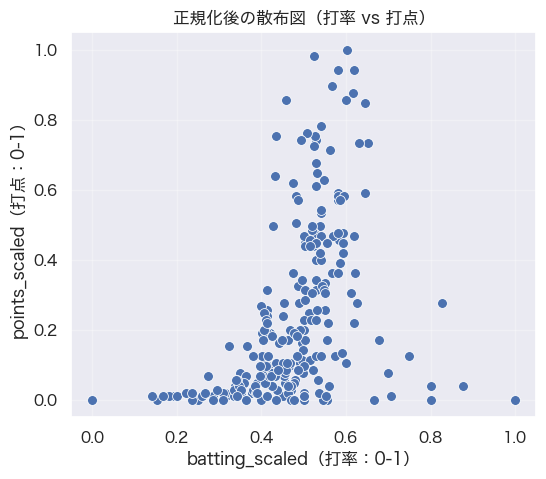

In [13]:
# 正規化後の打率と打点の散布図を描画する
plt.figure(figsize=(6, 5))
sns.scatterplot(data=dataset, x="batting_scaled", y="points_scaled", s=50, edgecolor="white")
plt.title("正規化後の散布図（打率 vs 打点）")
plt.xlabel("batting_scaled（打率：0-1）")
plt.ylabel("points_scaled（打点：0-1）")
plt.grid(True, alpha=0.3)
plt.show()

## 5. クラスター数の決定

エルボーメソッドとシルエットプロットを使用してクラスター数を決定しましょう

### クラスタリングを行なうデータの抽出

In [15]:
# datasetからbatting_scaledとpoints_scaledを取り出して、numpy配列に変換してXに格納する
X = dataset[["batting_scaled", "points_scaled"]].to_numpy()

# Xの形状を確認
print("X shape:", X.shape)

X shape: (241, 2)


### エルボーメソッド

In [20]:
# 最大クラスター数を10として、クラスター数1から10までのWCSS値を算出（変更しないでください）
wcss = []
c_list = np.arange(1, 11)

In [21]:
# wcssとc_listの中身を確認
print("wcss=",wcss)
print("c_list=",c_list)

wcss= []
c_list= [ 1  2  3  4  5  6  7  8  9 10]


In [22]:
# クラスタ数の算出
for c in c_list:
    km = KMeans(n_clusters=c, random_state=42, n_init=10)
    km.fit(X)
    wcss.append(km.inertia_)

In [23]:
# WCSSの表示（変更しないでください）
wcss

[19.166235457325392,
 7.41051670525134,
 5.19035543662267,
 3.6886547855136658,
 2.5958700849196963,
 1.9263829763388605,
 1.6806578975971247,
 1.4198474369987677,
 1.2299161115952686,
 1.105112588365459]

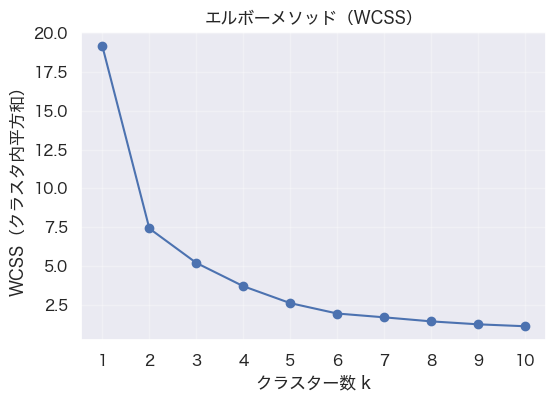

In [24]:
# エルボーメソッドのグラフの表示
plt.figure(figsize=(6, 4))
plt.plot(c_list, wcss, marker="o")
plt.xticks(c_list)
plt.title("エルボーメソッド（WCSS）")
plt.xlabel("クラスター数 k")
plt.ylabel("WCSS（クラスタ内平方和）")
plt.grid(True, alpha=0.3)
plt.show()

### シルエットプロット

In [25]:
# クラスタ数を6に指定（変更しないでください）
cluster_no = 6

In [26]:
# クラスタリングのモデルを作成し、学習して、クラスタ番号を取得
km6 = KMeans(n_clusters=cluster_no, random_state=42, n_init=10)
labels6 = km6.fit_predict(X)

In [28]:
# シルエットスコアの平均値
sil_avg = silhouette_score(X, labels6)
print(f"平均シルエットスコア（k=6）: {sil_avg:.3f}")

# 各データのシルエットスコア
sample_sil = silhouette_samples(X, labels6)

平均シルエットスコア（k=6）: 0.444


In [29]:
# sample_silの中身を表示
sample_sil

array([0.66036649, 0.67753592, 0.54577155, 0.53673516, 0.60743344,
       0.66976431, 0.42736023, 0.40093494, 0.25283156, 0.56932744,
       0.07443492, 0.58937725, 0.06053258, 0.55365386, 0.48221475,
       0.06053258, 0.51296588, 0.63671055, 0.62230151, 0.57482832,
       0.21064871, 0.63059293, 0.4623776 , 0.30470431, 0.56348519,
       0.64761119, 0.33195457, 0.0432687 , 0.5536254 , 0.48162082,
       0.45603888, 0.15461041, 0.28119661, 0.54662346, 0.48035648,
       0.2936484 , 0.55322621, 0.54176621, 0.10858343, 0.62185286,
       0.62409968, 0.41650324, 0.39904681, 0.49814067, 0.67406935,
       0.59096362, 0.52317131, 0.6818641 , 0.36186881, 0.65287384,
       0.46566224, 0.46192695, 0.55379691, 0.50756694, 0.23356244,
       0.1193324 , 0.3930595 , 0.51272383, 0.59258314, 0.59548608,
       0.6033586 , 0.5971612 , 0.50555691, 0.43839249, 0.43178018,
       0.45525145, 0.54486086, 0.50176911, 0.54256329, 0.64850615,
       0.52512039, 0.52907847, 0.37994585, 0.1094563 , 0.51944

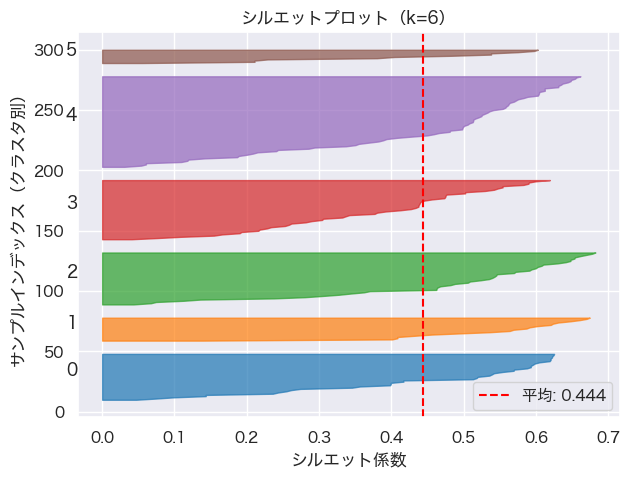

In [30]:
# シルエットプロットを描画
plt.figure(figsize=(7, 5))
y_lower = 10
for i in range(cluster_no):
    ith_cluster_sil = sample_sil[labels6 == i]
    ith_cluster_sil.sort()
    size_i = ith_cluster_sil.shape[0]
    y_upper = y_lower + size_i
    color = sns.color_palette("tab10", cluster_no)[i]
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_i, str(i))
    y_lower = y_upper + 10  # 10pxの間隔
plt.axvline(x=sil_avg, color="red", linestyle="--", label=f"平均: {sil_avg:.3f}")
plt.title("シルエットプロット（k=6）")
plt.xlabel("シルエット係数")
plt.ylabel("サンプルインデックス（クラスタ別）")
plt.legend()
plt.show()

## 6. 結果の確認

上記の結果をもとに、クラスタ数6で再度クラスタリングを実行し、分類ごとに色を分けて散布図にプロットしましょう。

In [31]:
# クラスタ数を6に指定（変更しないでください）
cluster_no = 6

# クラスタリングのモデルを作成し、学習して、クラスタ番号を取得
kmeans = KMeans(n_clusters=cluster_no, random_state=42, n_init=10)
dataset["cluster"] = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

In [ ]:
# centersの中身を表示
centers

array([[0.27107692, 0.02197802],
       [0.5572    , 0.81571429],
       [0.54381818, 0.49458874],
       [0.48652   , 0.24380952],
       [0.45989474, 0.06403509],
       [0.789     , 0.06111111]])

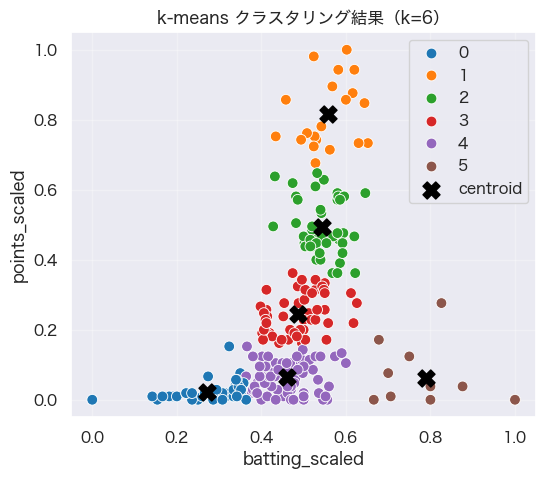

In [ ]:
# k-means法によるクラスタリングの結果を描画
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=dataset, x="batting_scaled", y="points_scaled",
    hue="cluster", palette="tab10", s=60, edgecolor="white"
)
# 重心を描画
## batting_scaled = 打率 1に近い方が打率がいい
## points_scaled = 打点 1に近い方が打点が多い
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=150, marker="X", label="centroid")
plt.title("k-means クラスタリング結果（k=6）")
plt.xlabel("batting_scaled")
plt.ylabel("points_scaled")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()